**Human Activity Prediction**

Prever qual a atividade da pessoa seguindo a classificação:

1.  WALKING
2.  WALKING_UPSTAIRS
3.  WALKING_DOWNSTAIRS
4.  SITTING
5.  STANDING
6.  LAYING


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings('ignore',category=UserWarning)

In [3]:
# Importing the data
df_train = pd.read_csv("/content/drive/MyDrive/Carlos Hanft/DataScience/Projeto 3/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Carlos Hanft/DataScience/Projeto 3/test.csv")

# Unify both datasets
df = pd.concat([df_train,df_test]).reset_index().drop('index',axis=1)

In [4]:
# Rows and columns
print(f'> Data has {df.shape[0]} rows and {df.shape[1]} columns')
print(f'> Training data has {df_train.shape[0]} rows and {df_train.shape[1]} columns')
print(f'> Test data has {df_test.shape[0]} rows and {df_test.shape[1]} columns')

> Data has 10299 rows and 563 columns
> Training data has 7352 rows and 563 columns
> Test data has 2947 rows and 563 columns


In [5]:
# Checking null values
print(f'> Data has {df.isnull().sum().sum()} null values\n')
print('> NO NULL VALUES !!')

> Data has 0 null values

> NO NULL VALUES !!


In [6]:
# Check if there any duplicated row
print(f'> Data has {df.duplicated().sum()} duplicated values')

> Data has 0 duplicated values


In [7]:
# Quick overview into the data structure
print('Training data')
df_train.info(memory_usage=True,)
print('\n')
print('Test data')
df_test.info(memory_usage=True)

Training data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


Test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


# EDA

In [8]:
# 563 columns
df.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [9]:
# Statistical summary
df.describe().round(2)

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  ...  angle(Z,gravityMean)   subject
count           10299.00           10299.00  ...              10299.00  10299.00
mean                0.27              -0.02  ...                 -0.05     16.15
std                 0.07               0.04  ...                  0.27      8.68
min                -1.00              -1.00  ...                 -1.00      1.00
25%                 0.26              -0.02  ...                 -0.13      9.00
50%                 0.28              -0.02  ...                 -0.00     17.00
75%                 0.29              -0.01  ...                  0.10     24.00
max                 1.00               1.00  ...                  1.00     30.00

[8 rows x 562 columns]

In [10]:
# Removing unwanted characters in columns names
df.columns = df.columns.str.replace(pat='([-(),\s])',repl='')
df_train.columns = df_train.columns.str.replace(pat='([-(),\s])',repl='')
df_test.columns = df_test.columns.str.replace(pat='([-(),\s])',repl='')

In [11]:
# No repeated feature in the dataset
print('num of columns: ',len(df.columns))
print('num of unique columns: ', df.columns.nunique())

num of columns:  563
num of unique columns:  563


In [12]:
# List contains categories ordered by quantity to be used in plot
sub_index = df.subject.value_counts().index
act_index = df.Activity.value_counts().index

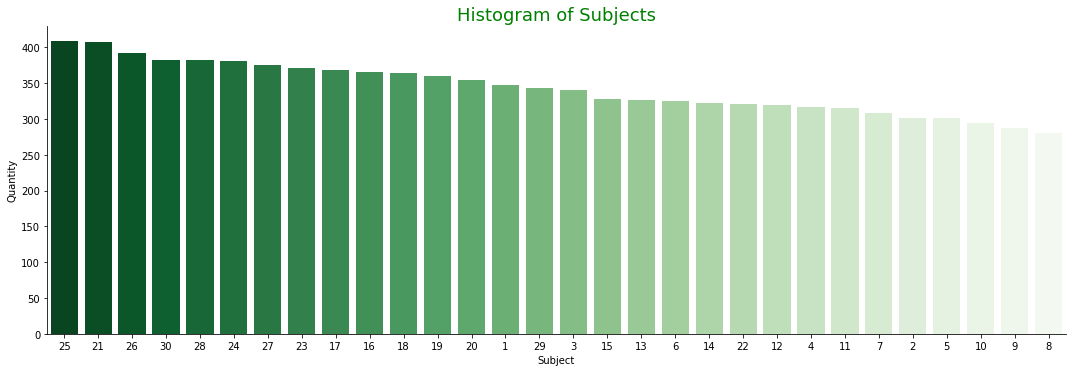

In [13]:
# Histogram: number of samples for each subject
sns.catplot(x='subject', kind='count', aspect=3, height=5, palette='Greens_r', order=sub_index, data=df)

plt.title('Histogram of Subjects',fontsize=18, color='g')
plt.ylabel('Quantity')
plt.xlabel('Subject')
plt.show()

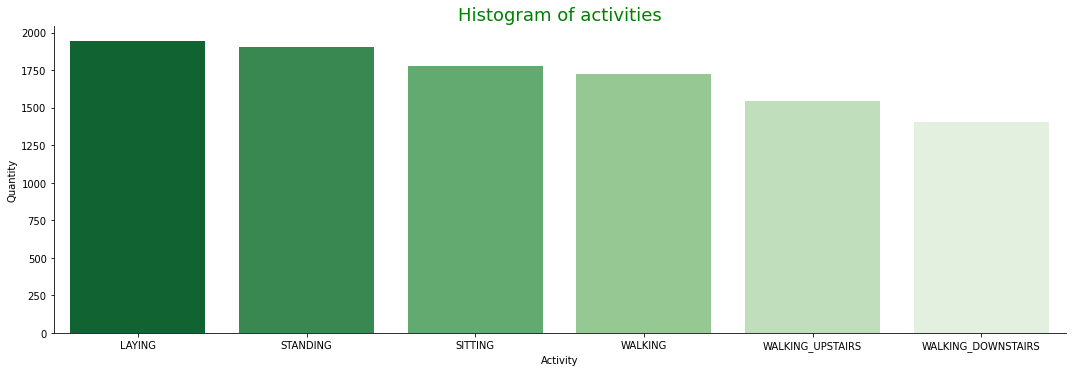

In [14]:
# Histogram: number of samples per activity
sns.catplot(x='Activity', kind='count', aspect=3, height=5, palette='Greens_r', order=act_index, data=df)

plt.title('Histogram of activities',fontsize=18, color='g')
plt.ylabel('Quantity')
plt.xlabel('Activity')
plt.show()

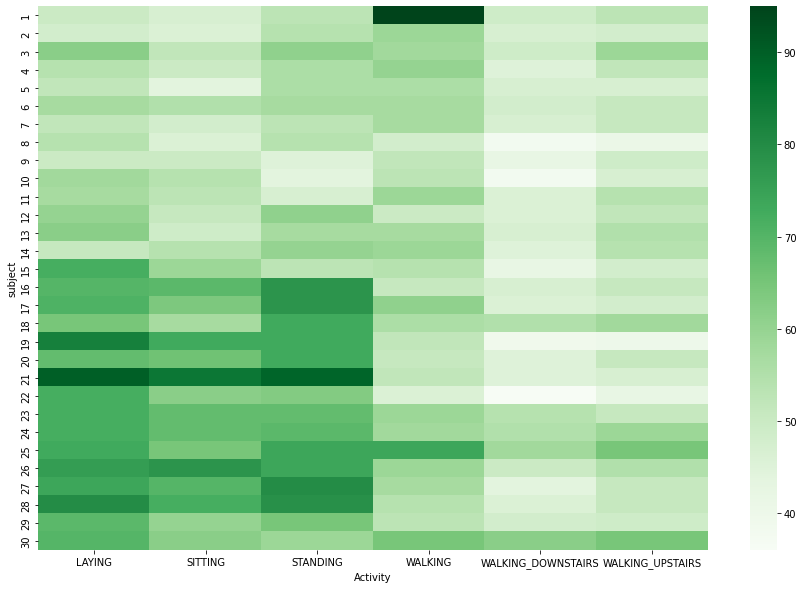

In [15]:
# Heatmap: subject vs activity
plt.figure(figsize=(15,10))
sns.heatmap(data=pd.crosstab(df.subject, df.Activity), cmap='Greens')
plt.show()

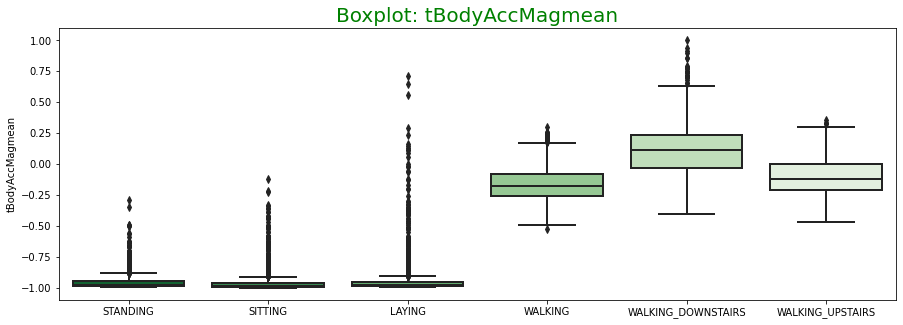

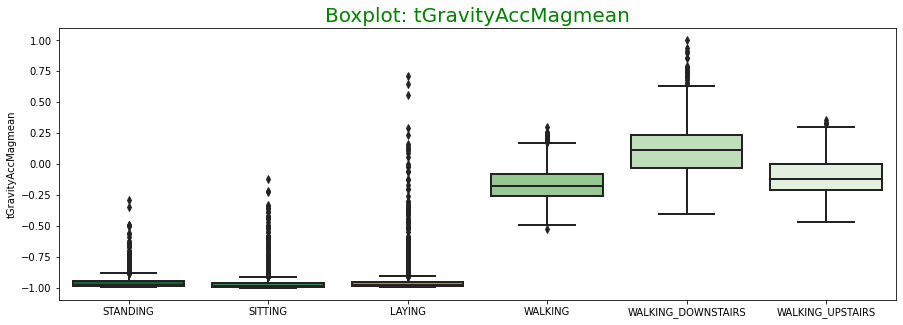

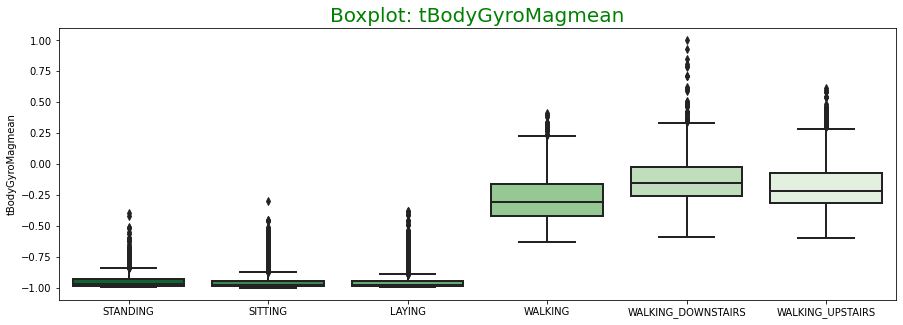

In [16]:
# Boxplot for mean acceleration features grouped by activity
cols = df.columns[df.columns.str.contains('t(Body|Gravity)(Acc|Gyro)Magmean')]

for col in cols:

    plt.figure(figsize=(15,5))
    sns.boxplot(x='Activity', y=col, data=df, linewidth=2, palette='Greens_r')
    plt.title(f'Boxplot: {col}', fontsize=20, color='g')
    plt.xlabel(None)
    plt.show()
    print('\n')

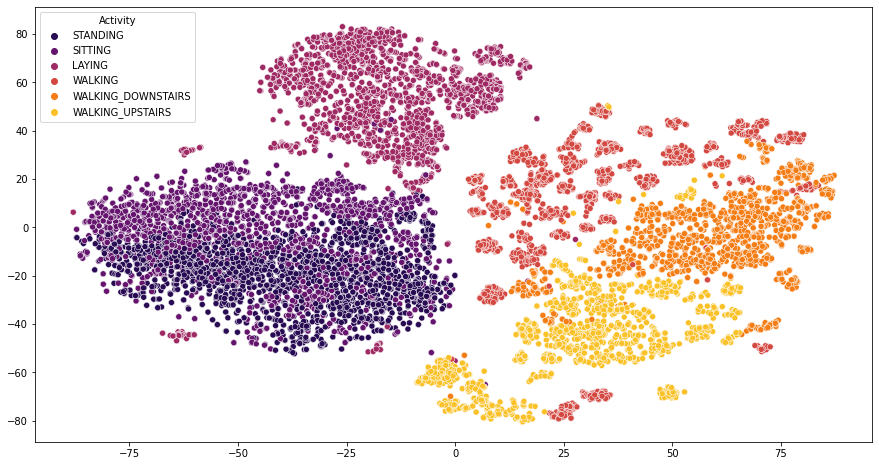

In [17]:
# Are the classes separable ? 
tsne_data = df.copy()
activity_data = tsne_data.pop('Activity')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (to speed up processing)
pca = PCA(n_components=0.9, random_state=42)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=42)
tsne_transformed = tsne.fit_transform(tsne_data)

# Plot t-SNE results
plt.figure(figsize=(15,8))
sns.scatterplot(
    x=tsne_transformed[:,0],
    y=tsne_transformed[:,1],
    hue=activity_data,
    palette='inferno'
)
plt.show()

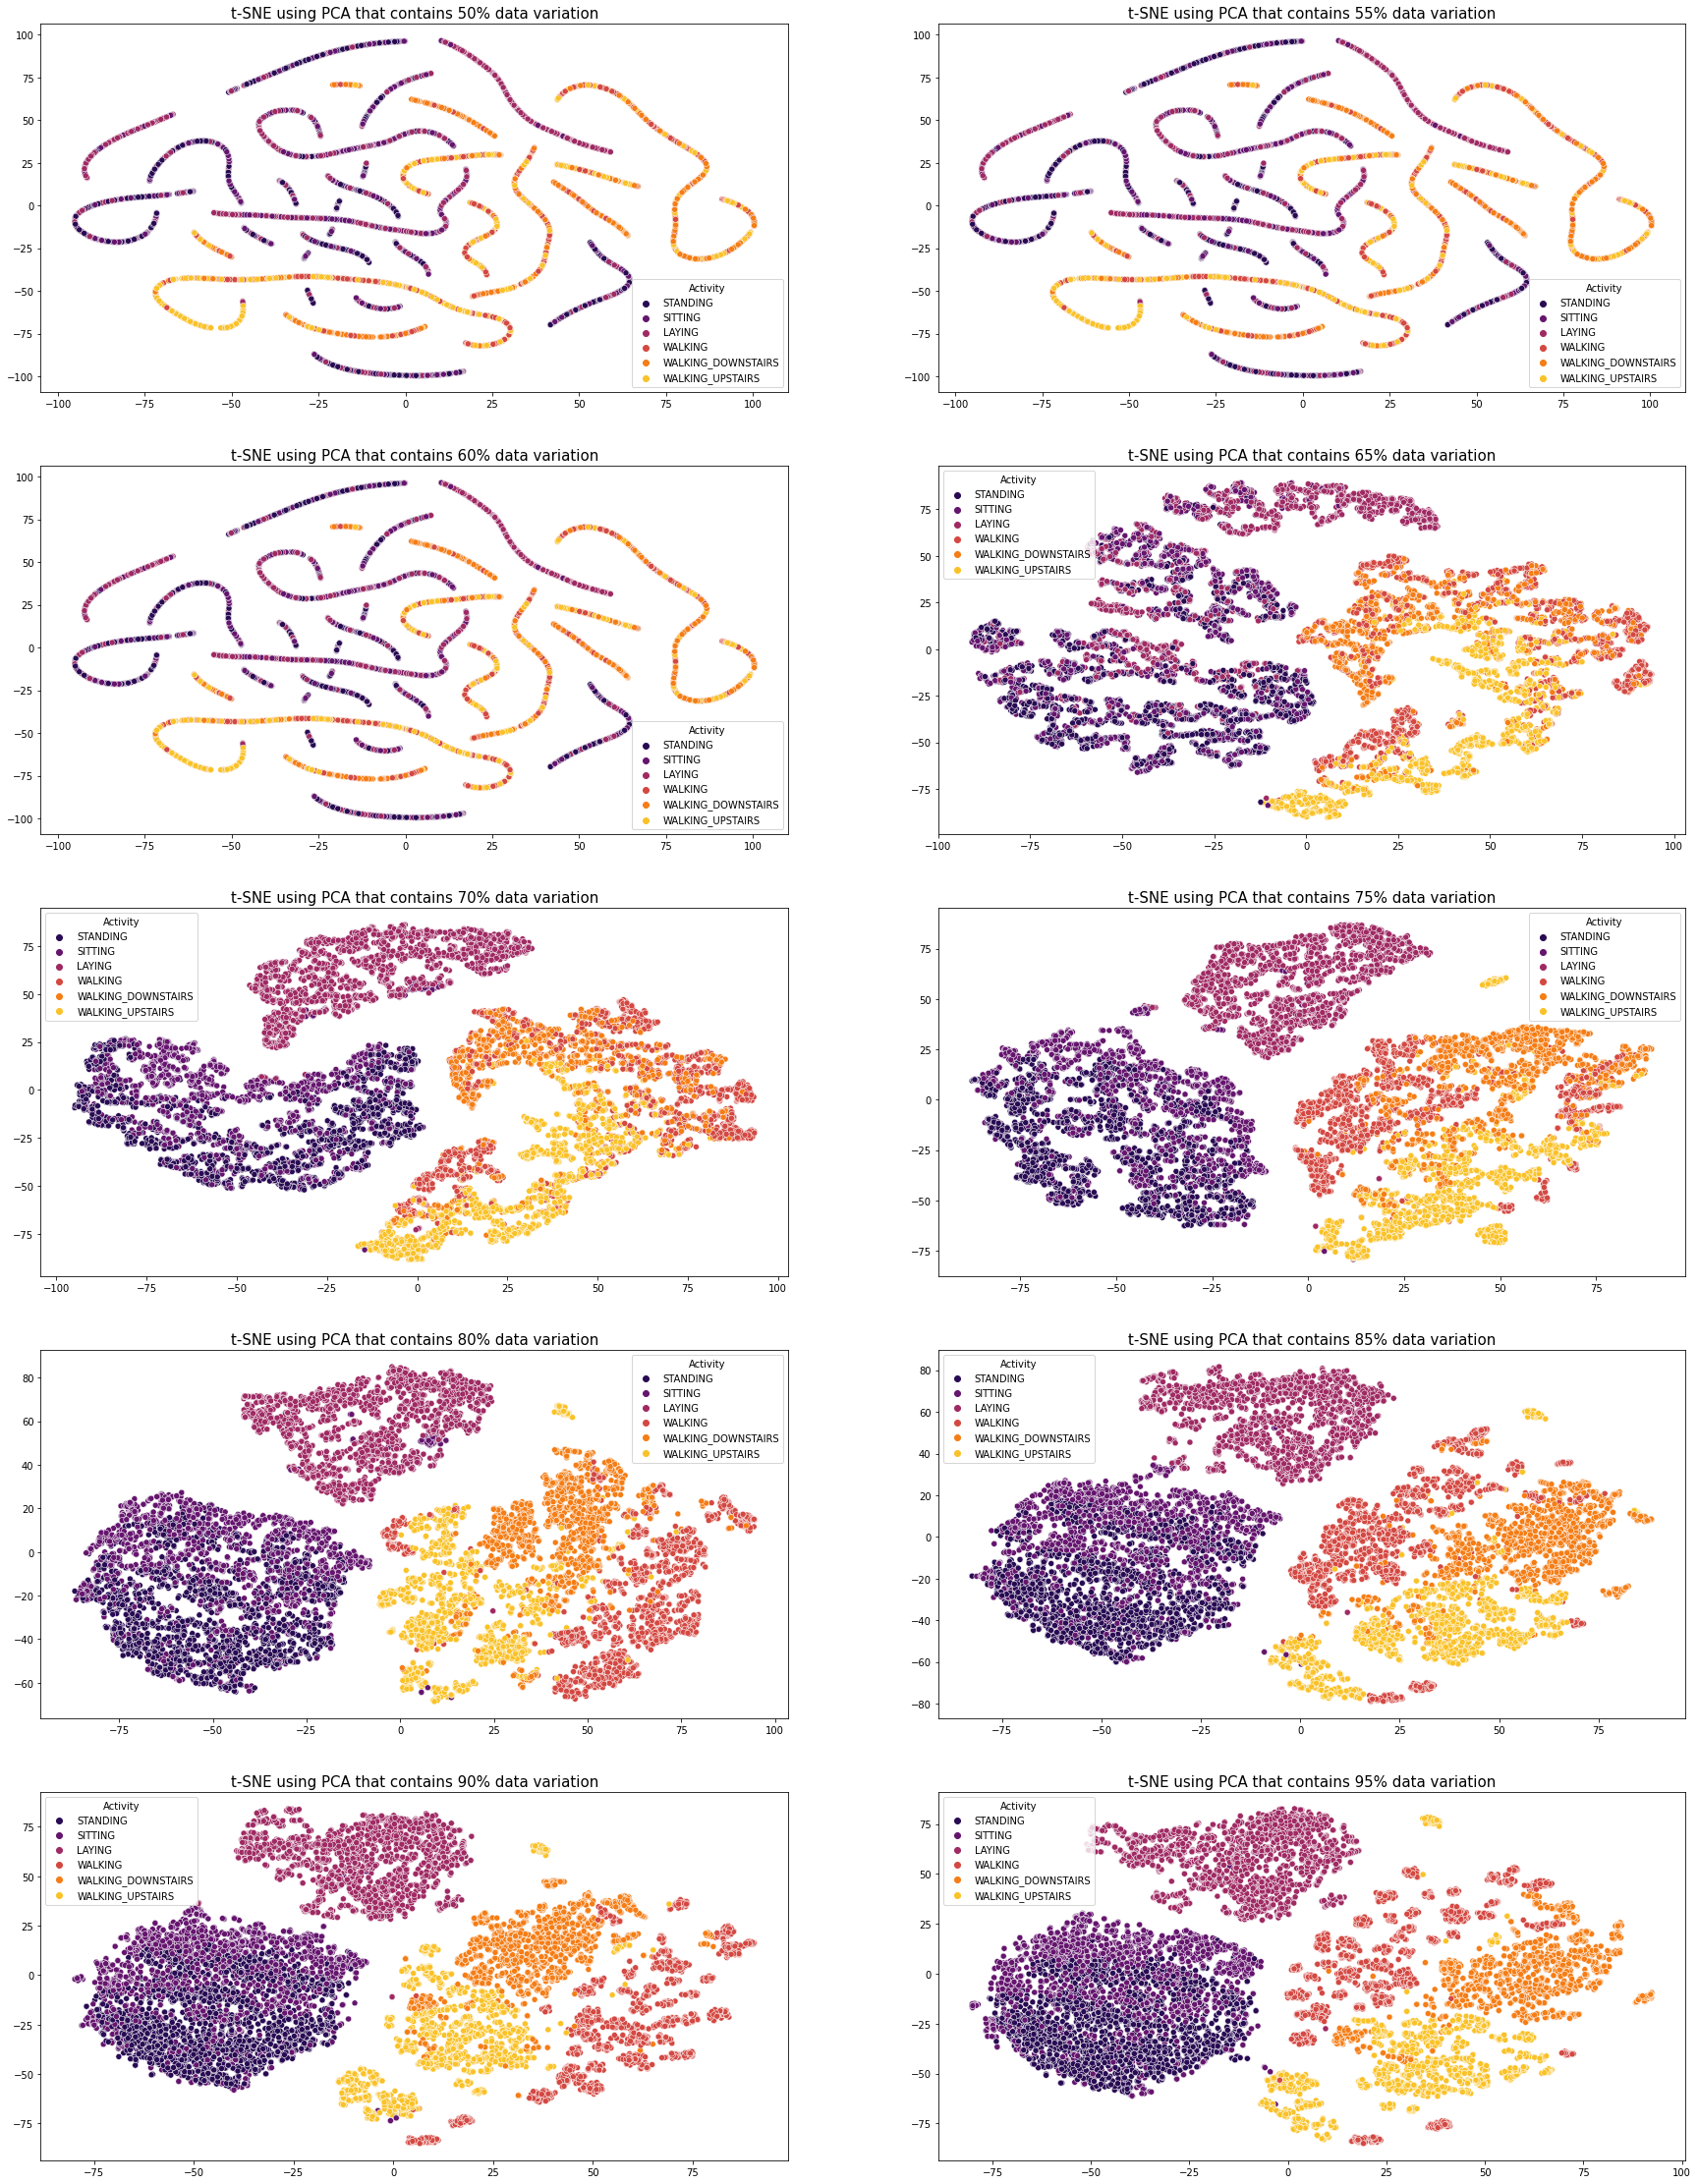

In [33]:
# Define N_components values to be tested
n_comp_params = np.arange(0.5,1,0.05)

# Create figure with multiple axis
fig, axs = plt.subplots(5,2,figsize=(30,40))

# Constant for row and col to loop through each axis in figure
r = 0
c = 0

for n in n_comp_params:

    #get main data
    tsne_data = df.copy()
    activity_data = tsne_data.pop('Activity')
    subject_data = tsne_data.pop('subject')

    #apply PCA with "n" parameter
    pca = PCA(n_components=n, random_state=42)
    tsne_data = pca.fit_transform(tsne_data)

    #apply tsne on the transformed data
    tsne = TSNE(random_state=42)
    tsne_transformed = tsne.fit_transform(tsne_data)

    #plot tsne data for each category
    sns.scatterplot(x=tsne_transformed[:,0],
                    y=tsne_transformed[:,1],
                    hue=activity_data,
                    palette='inferno',
                    ax=axs[r,c])
    
    #add labels to plot
    axs[r,c].set_title(f't-SNE using PCA that contains {n:.0%} data variation', fontsize=15)

    #add one to constant and reset column constant value
    if c == 1:
        r+=1
        c=0
    else:
        c+=1

plt.show()

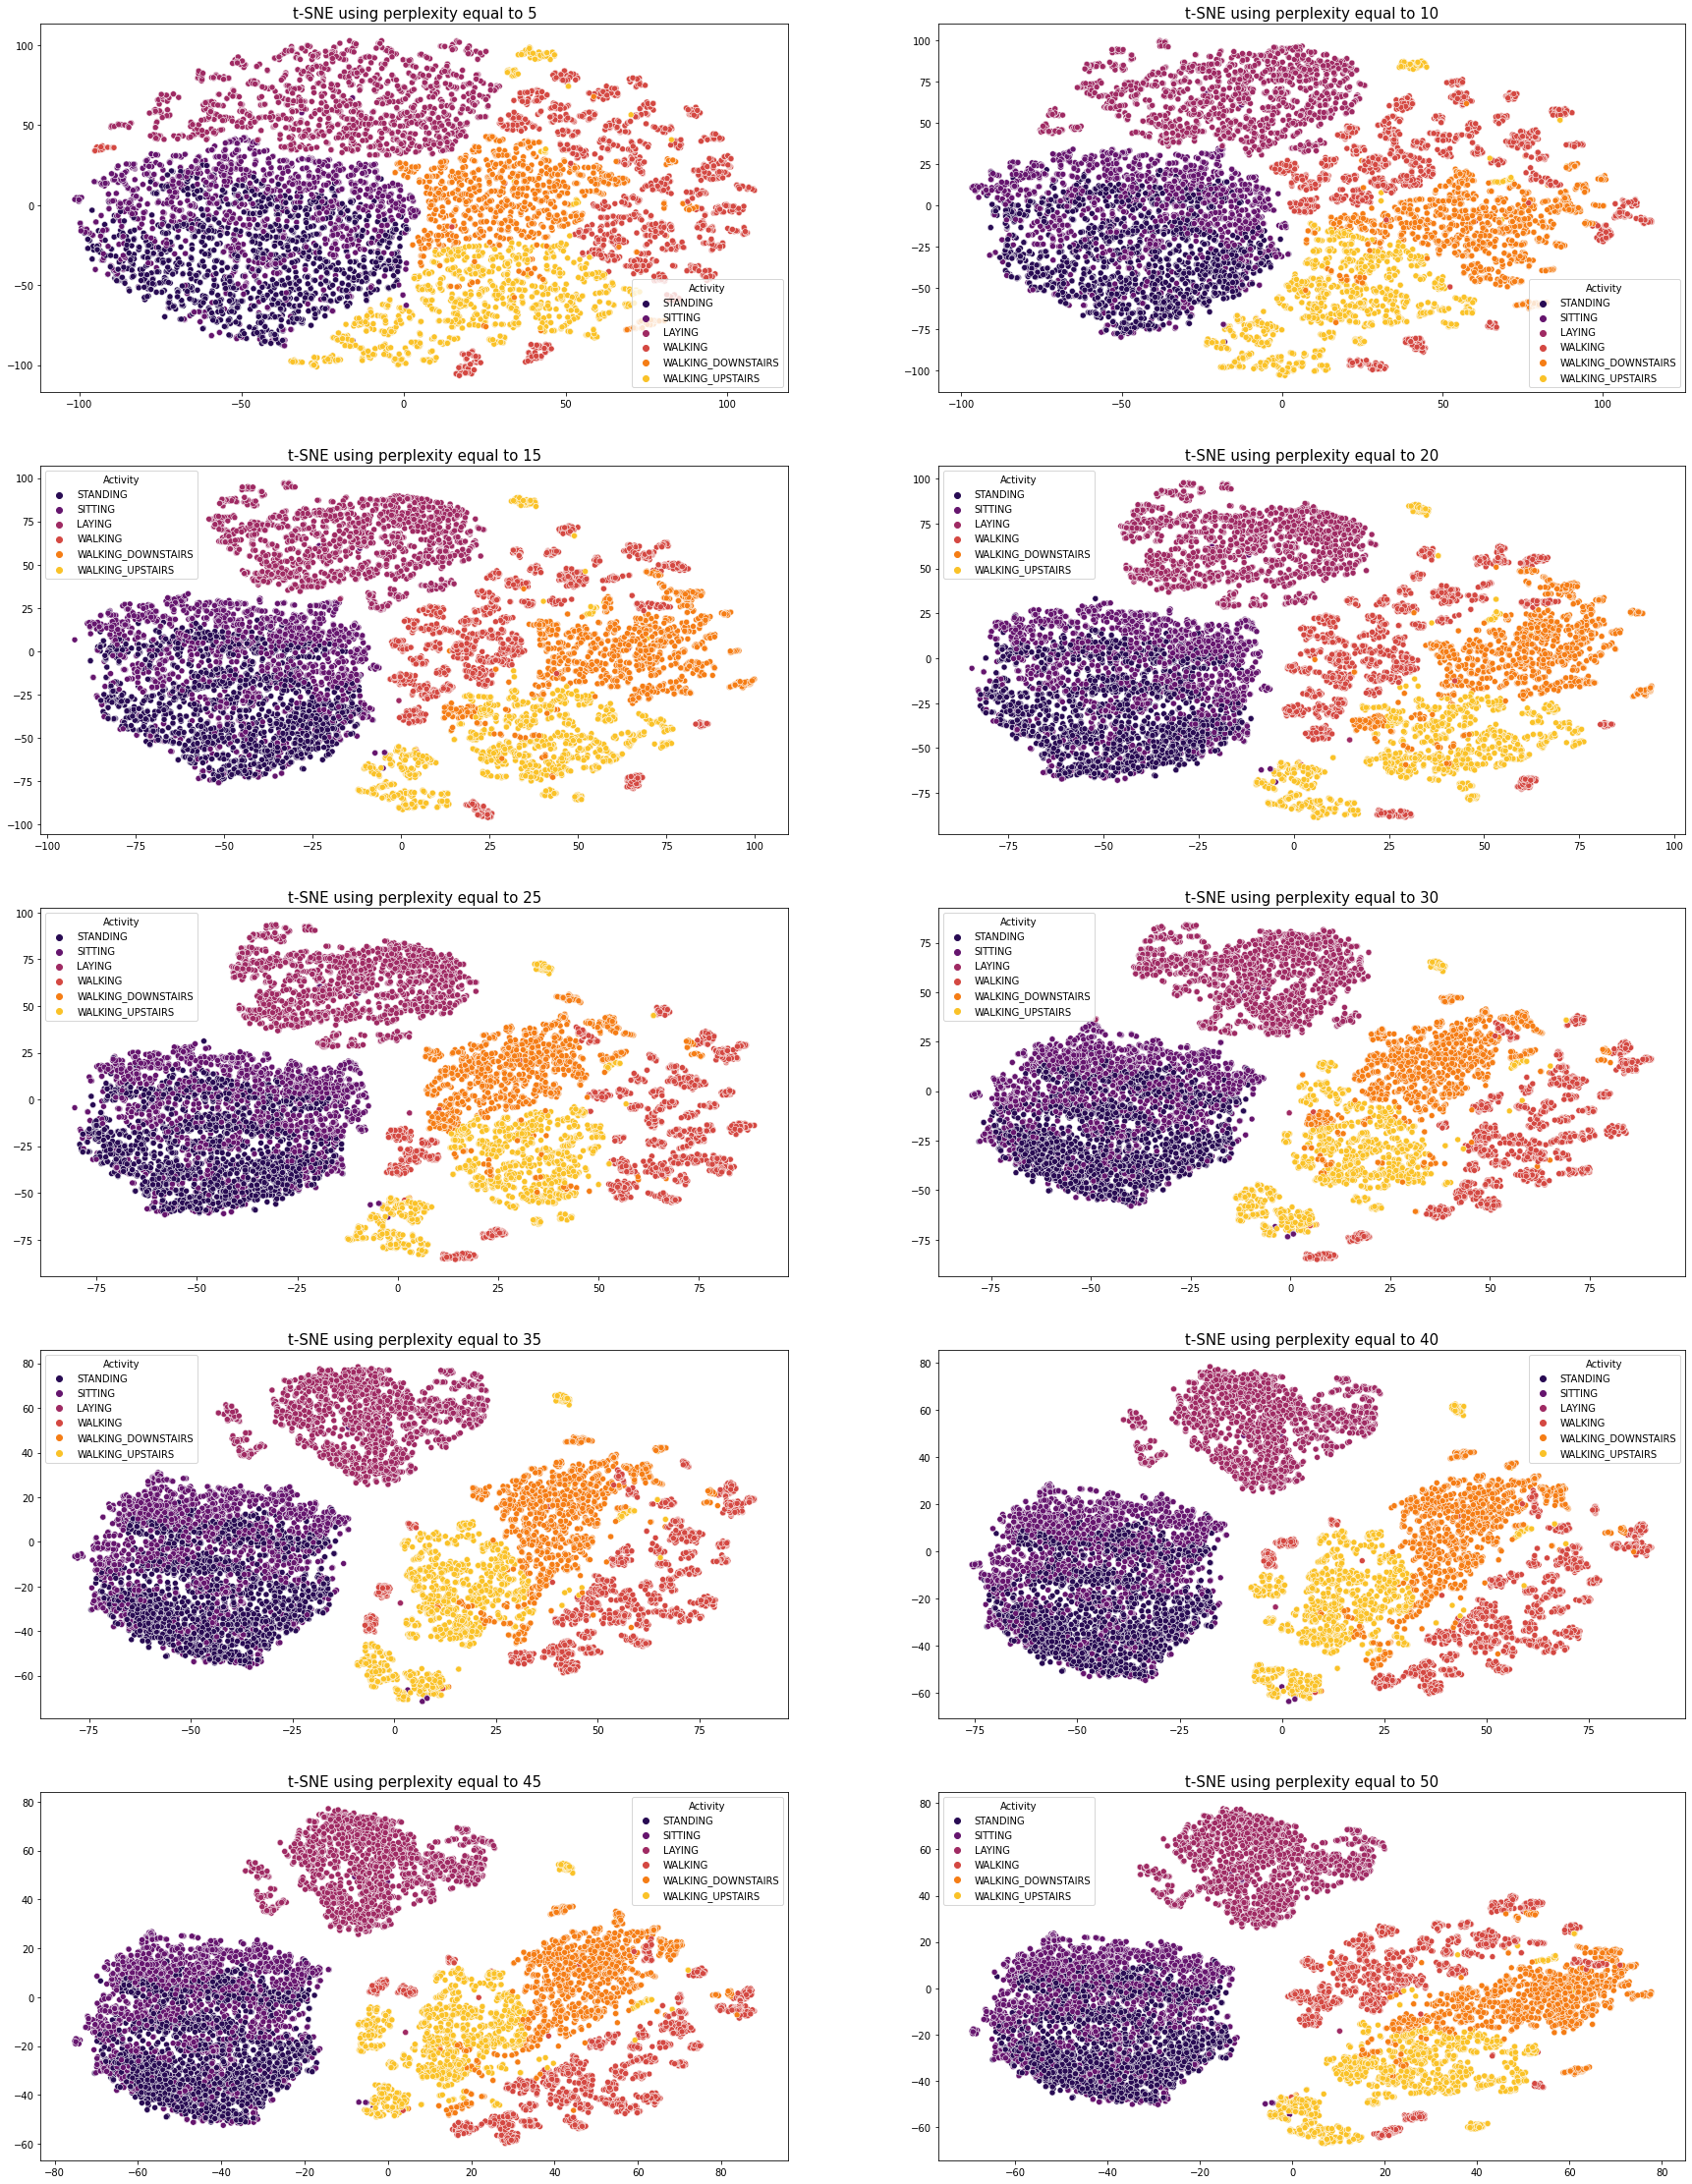

In [34]:
# Define perplexity values to be tested
perplexity_params = np.arange(5,55,5)

# Create figure with multiple axis
fig, axs = plt.subplots(5,2,figsize=(30,40))

# Constant for row and col to loop through each axis in figure
r = 0
c = 0

for n in perplexity_params:

    #get main data
    tsne_data = df.copy()
    activity_data = tsne_data.pop('Activity')
    subject_data = tsne_data.pop('subject')

    #apply PCA
    pca = PCA(n_components=0.9, random_state=42)
    tsne_data = pca.fit_transform(tsne_data)

    #apply tsne on the transformed data with parameter
    tsne = TSNE(random_state=42, perplexity=n)
    tsne_transformed = tsne.fit_transform(tsne_data)

    #plot tsne data for each category
    sns.scatterplot(x=tsne_transformed[:,0],
                    y=tsne_transformed[:,1],
                    hue=activity_data,
                    palette='inferno',
                    ax=axs[r,c])
    
    #add labels to plot
    axs[r,c].set_title(f't-SNE using perplexity equal to {n}', fontsize=15)

    #add one to constant and reset column constant value
    if c == 1:
        r+=1
        c=0
    else:
        c+=1

plt.show()

# Building our model

In [18]:
# Split data in target and features
y_train = df_train.Activity
X_train = df_train.drop(['subject', 'Activity'], axis=1)
y_test = df_test.Activity
X_test = df_test.drop(['subject', 'Activity'], axis=1)

In [19]:
#How data was split
print(f'Train data is {X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]):.0%} of total data')
print(f'Test data is {X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]):.0%} of total data')

Train data is 71% of total data
Test data is 29% of total data


In [20]:
#check target distribution in both train and test data
pd.concat([y_train.value_counts(normalize=True).rename('Train'),y_test.value_counts(normalize=True).rename('Test')], axis=1)

Train      Test
LAYING              0.191376  0.182219
STANDING            0.186888  0.180523
SITTING             0.174918  0.166610
WALKING             0.166757  0.168307
WALKING_UPSTAIRS    0.145947  0.159824
WALKING_DOWNSTAIRS  0.134113  0.142518

## Logistic Regression

In [21]:
# Params for gridsearch
parameters = {'C':[0.01, 0.1, 1, 10, 20]}

# Fit predict
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=42)

lr_grid = GridSearchCV(lr, param_grid=parameters, cv=3, scoring='accuracy')

lr_grid.fit(X_train, y_train)

lr_grid.best_estimator_.fit(X_train,y_train)

y_pred = lr_grid.best_estimator_.predict(X_test)

# Classification report
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.87      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.98       420
  WALKING_UPSTAIRS       0.97      0.95      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



## LightGBM

In [22]:
# Params for gridsearch
parameters = {'num_leaves':[6,9], 'min_data_in_leaf':[300,400], 'max_depth':[10,15,20]}

# Fit predict
lgbm = LGBMClassifier(random_state=42)

lgbm_grid = GridSearchCV(lgbm, param_grid=parameters, cv=3, scoring='accuracy')

lgbm_grid.fit(X_train, y_train)

lgbm_grid.best_estimator_.fit(X_train,y_train)

y_pred = lgbm_grid.best_estimator_.predict(X_test)

# Classification report
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.93      0.89      0.91       491
          STANDING       0.90      0.94      0.92       532
           WALKING       0.94      1.00      0.96       496
WALKING_DOWNSTAIRS       0.98      0.92      0.95       420
  WALKING_UPSTAIRS       0.94      0.93      0.93       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



## Feature Importances

In [23]:
# Get feature importances
features = X_test.columns
importances = lgbm_grid.best_estimator_.feature_importances_

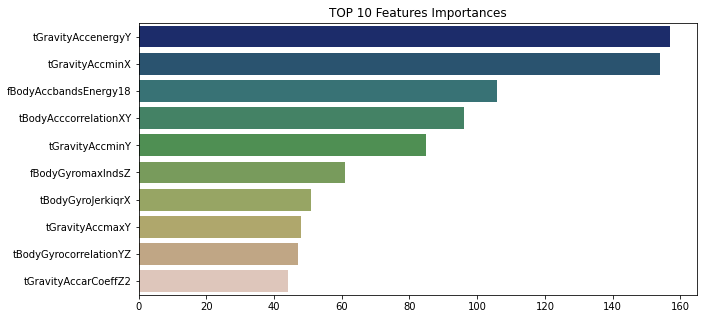

In [24]:
# Plot top 10 features importances
dfplot = pd.DataFrame(importances,
                      index=features,
                      columns=['importance']).sort_values('importance', ascending=False).head(10).T

plt.figure(figsize=(10,5))
sns.barplot(data=dfplot, orient='h', palette='gist_earth')
plt.title('TOP 10 Features Importances')
plt.show()

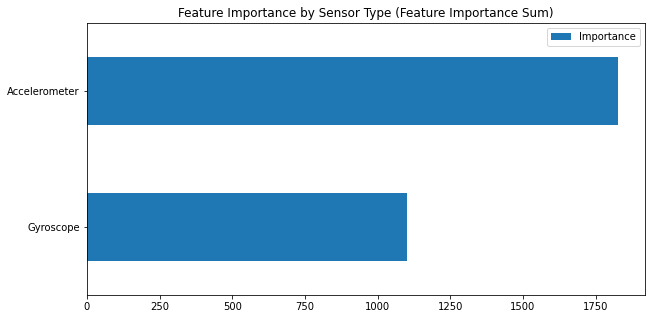

In [25]:
# Group importances for each sensor type
data = {'Gyroscope':0, 'Accelerometer':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Accelerometer'] += importance

# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'})
sensor_df.plot(kind='barh', figsize=(10,5), title='Feature Importance by Sensor Type (Feature Importance Sum)')
plt.show()

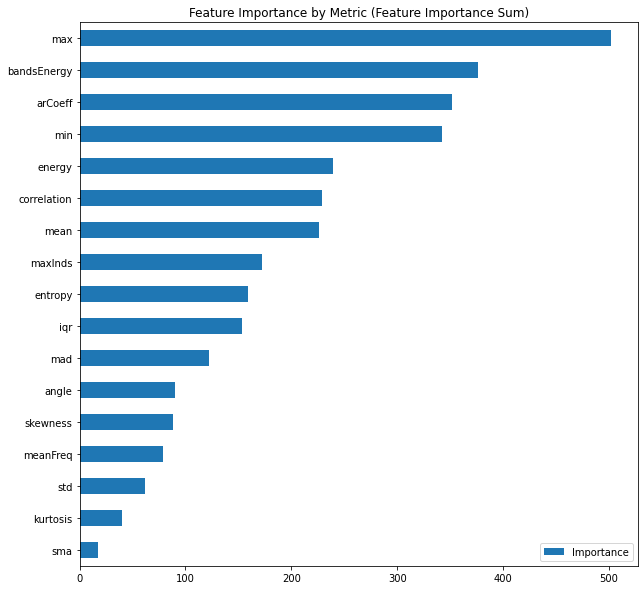

In [26]:
# Group importances for each metric
data = {'mean':0,'std':0,'mad':0,'max':0,'min':0,'sma':0,'energy':0,'iqr':0,
        'entropy':0,'arCoeff':0,'correlation':0,'maxInds':0,'meanFreq':0,
        'skewness':0,'kurtosis':0,'bandsEnergy':0,'angle':0}

for importance, feature in zip(importances, features):
    if 'mean' in feature:
        data['mean'] += importance
    if 'std' in feature:
        data['std'] += importance
    if 'mad' in feature:
        data['mad'] += importance
    if 'max' in feature:
        data['max'] += importance
    if 'min' in feature:
        data['min'] += importance
    if 'sma' in feature:
        data['sma'] += importance
    if 'energy' in feature:
        data['energy'] += importance
    if 'iqr' in feature:
        data['iqr'] += importance
    if 'entropy' in feature:
        data['entropy'] += importance
    if 'arCoeff' in feature:
        data['arCoeff'] += importance
    if 'correlation' in feature:
        data['correlation'] += importance
    if 'maxInds' in feature:
        data['maxInds'] += importance
    if 'meanFreq' in feature:
        data['meanFreq'] += importance
    if 'skewness' in feature:
        data['skewness'] += importance
    if 'kurtosis' in feature:
        data['kurtosis'] += importance
    if 'bandsEnergy' in feature:
        data['bandsEnergy'] += importance
    if 'angle' in feature:
        data['angle'] += importance

# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'}).sort_values('Importance')
sensor_df.plot(kind='barh', figsize=(10,10), title='Feature Importance by Metric (Feature Importance Sum)')
plt.show()

## Feature selection
We got a lot of columns so we should better look carefully whether all of them are truly useful for our purposes.

In [27]:
# Instantiate 
vt = VarianceThreshold()

# Fit it and transform training data
vt.fit_transform(X_train)

X_train_transf = X_train.loc[:, vt.get_support()] 
X_test_transf = X_test.loc[:, vt.get_support()]

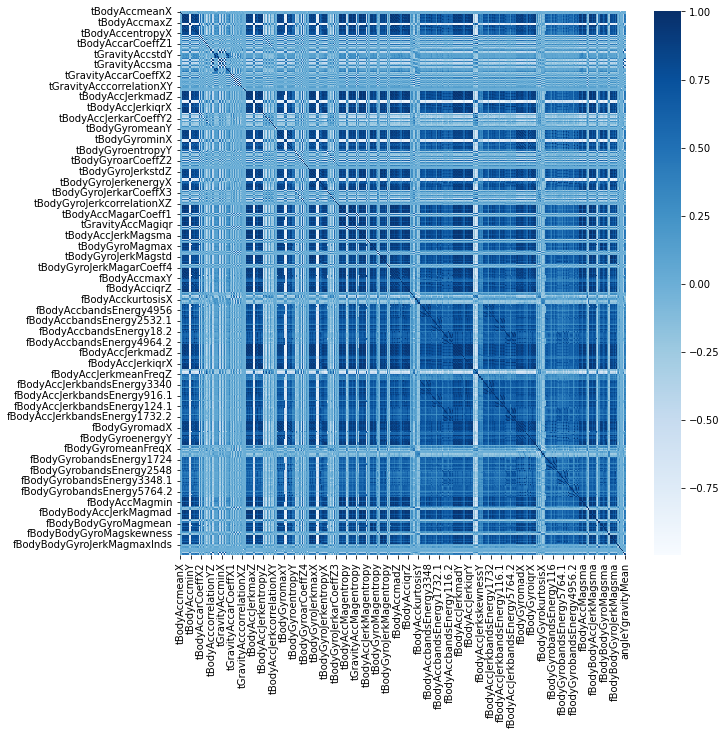

In [28]:
# Highly correlated features
plt.figure(figsize=(10,10))
sns.heatmap(data=X_train_transf.corr(), cmap='Blues', center=0)
plt.show()

In [29]:
# Set threshold
threshold = 0.98

# Find list of columns where correlation is above the threshold
cols_corr_drop = X_train_transf.columns[sum(np.tril(X_train_transf.corr().abs(),-1)>=threshold)>0]

In [30]:
# Remove all highly correlated features
X_train_transf.drop(cols_corr_drop,axis=1, inplace=True)
X_test_transf.drop(cols_corr_drop,axis=1, inplace=True)

In [31]:
# Select the best features based on its importances
lgbm = LGBMClassifier(random_state=42).fit(X_train_transf, y_train)

model = SelectFromModel(
    estimator=lgbm,
    prefit=True
    )

X_train_new = X_train_transf.loc[:, model.get_support()]
X_test_new = X_test_transf.loc[:, model.get_support()]

In [32]:
# Params for gridsearch
parameters = {'num_leaves':[6,9,12], 'min_data_in_leaf':[300,400,500], 'max_depth':[10,15,20]}

# Fit predict
lgbm = LGBMClassifier(random_state=42)

lgbm_grid = GridSearchCV(lgbm, param_grid=parameters, cv=3, scoring='accuracy')

lgbm_grid.fit(X_train_new, y_train)

lgbm_grid.best_estimator_.fit(X_train_new, y_train)

y_pred = lgbm_grid.best_estimator_.predict(X_test_new)

# Classification report
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.94      0.88      0.91       491
          STANDING       0.90      0.95      0.92       532
           WALKING       0.94      0.98      0.96       496
WALKING_DOWNSTAIRS       0.97      0.94      0.95       420
  WALKING_UPSTAIRS       0.94      0.93      0.94       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947

